In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)

tf.executing_eagerly()


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

stages = ['CE', 'SCL']

dataset = 'FairFace'
net = 'R50'
version = 'V1'

stage = stages[0]

script_name_template = '{}-{}-{}-BatchNorm-MultiOutput-AutoAug-224-{}'
script_name = script_name_template.format(version, dataset, net, stage)

In [2]:
if net == 'R50':
    from tensorflow.keras.applications.resnet_v2 import preprocess_input
    from tensorflow.keras.applications import ResNet50V2 as backbone_net
if net == 'Mnet':
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from tensorflow.keras.applications import MobileNetV2 as backbone_net

In [3]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [4]:
csv_target_train = '{}/train.csv'.format(dataset)
directory_data = dataset
df_train = pd.read_csv(csv_target_train)

if dataset == 'FairFace':
    csv_target_val = '{}/val.csv'.format(dataset)
    df_val = pd.read_csv(csv_target_val)
if dataset == 'UTKFace':
    directory_data = './'
    
df_train

,file,age,gender,race7,service_test,race
0,train/1.jpg,50-59,Male,East Asian,True,Asian
1,train/2.jpg,30-39,Female,Indian,False,Indian
2,train/3.jpg,3-9,Female,Black,False,Black
3,train/4.jpg,20-29,Female,Indian,True,Indian
4,train/5.jpg,20-29,Female,Indian,True,Indian
...,...,...,...,...,...,...
86739,train/86740.jpg,20-29,Male,Indian,True,Indian
86740,train/86741.jpg,10-19,Male,Indian,True,Indian
86741,train/86742.jpg,70+,Female,Indian,True,Indian
86742,train/86743.jpg,10-19,Female,Black,True,Black


In [5]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [6]:
target_col = ['gender', 'race', 'age']
if dataset == 'AFAD-Full':
    target_col = ['gender', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (224, 224, 3)
batch_size = 64
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.1
validation_split = 0.1

In [7]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)
    if dataset == 'FairFace':
        df_val[col2] = df_val.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [8]:
x_col = 'file'
y_col = target_col_data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    validation_split=validation_split
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
)


if dataset == 'FairFace':
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
    )

    val_iter = val_generator.flow_from_dataframe(
        df_val,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        shuffle=False,
    )
else:
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='training'
    )

    val_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='validation'
    )

Found 86744 validated image filenames.
Found 10954 validated image filenames.


In [9]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
        layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2)),
        layers.experimental.preprocessing.RandomContrast((0.1, 0.2))
        
    ]
)
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(augmented)
    outputs = resnet(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    return model

In [11]:
def create_classifier(encoder, trainable=True, training=True):
    
    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features_"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    metrics = {}
    loss = []
    loss_weights = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
        loss_weights.append(0.1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics,
        loss_weights=loss_weights
    )
    return model

In [12]:
encoder = create_encoder()
encoder.summary()
classifier = create_classifier(encoder)
classifier.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
rescaling (Rescaling)        (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________
Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)    

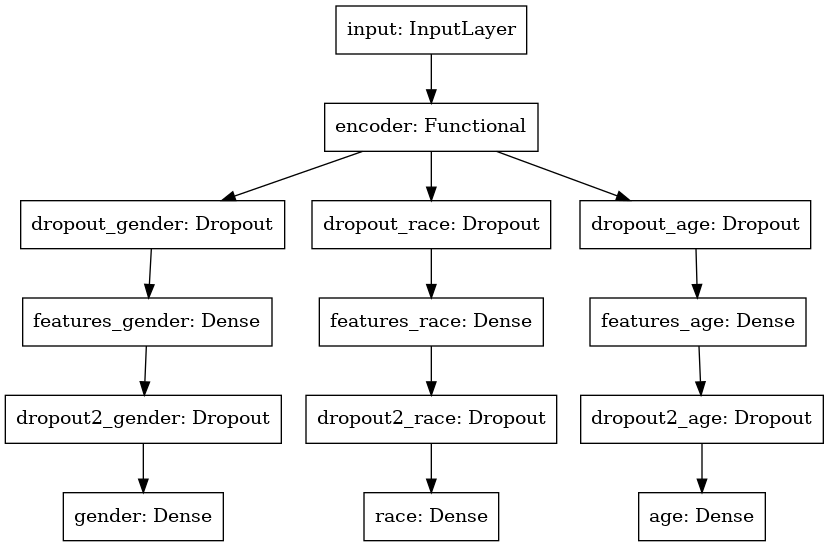

In [13]:
keras.utils.plot_model(classifier)

In [14]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)

classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Epoch 1/50
1356/1356 [==============================] - 479s 348ms/step - loss: 0.4093 - gender_loss: 0.6758 - race_loss: 1.5328 - age_loss: 1.8848 - gender_sparse_categorical_accuracy: 0.5889 - race_sparse_categorical_accuracy: 0.2939 - age_sparse_categorical_accuracy: 0.2914 - val_loss: 0.3960 - val_gender_loss: 0.6463 - val_race_loss: 1.4737 - val_age_loss: 1.8396 - val_gender_sparse_categorical_accuracy: 0.6205 - val_race_sparse_categorical_accuracy: 0.3449 - val_age_sparse_categorical_accuracy: 0.3035


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1356/1356 [==============================] - 294s 217ms/step - loss: 0.3841 - gender_loss: 0.6096 - race_loss: 1.4555 - age_loss: 1.7758 - gender_sparse_categorical_accuracy: 0.6577 - race_sparse_categorical_accuracy: 0.3602 - age_sparse_categorical_accuracy: 0.3170 - val_loss: 0.3624 - val_gender_loss: 0.5554 - val_race_loss: 1.3946 - val_age_loss: 1.6741 - val_gender_sparse_categorical_accuracy: 0.7022 - val_race_sparse_categorical_accuracy: 0.4009 - val_age_sparse_categorical_accuracy: 0.3489
Epoch 3/50
1356/1356 [==============================] - 277s 204ms/step - loss: 0.3428 - gender_loss: 0.5111 - race_loss: 1.2971 - age_loss: 1.6201 - gender_sparse_categorical_accuracy: 0.7369 - race_sparse_categorical_accuracy: 0.4542 - age_sparse_categorical_accuracy: 0.3541 - val_loss: 0.3122 - val_gender_loss: 0.4480 - val_race_loss: 1.1499 - val_age_loss: 1.5241 - val_gender_sparse_categorical_accuracy: 0.7813 - val_race_sparse_categorical_accuracy: 0.5209 - val_age_sparse_categ

In [15]:
stage = stages[1]
script_name = script_name_template.format(version, dataset, net, stage)

In [16]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

Model: "encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input_5[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      encoder[0][0]                    
__________________________________________________________________________________________________
features_race (Dense)           (None, 128)          262272      encoder[0][0]                    
_______________________________________________________________________

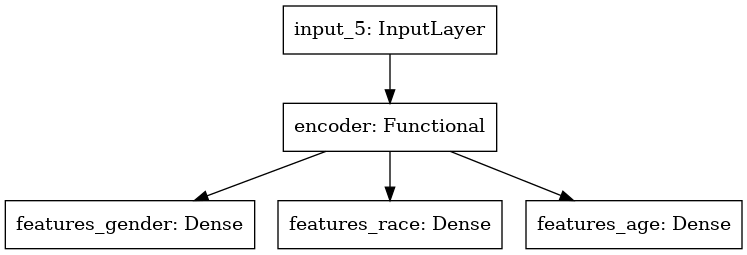

In [17]:
encoder = create_encoder()
loss = []
loss_weights = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
    loss_weights.append(0.1)
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
    loss_weights=loss_weights
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [18]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
1356/1356 [==============================] - 225s 162ms/step - loss: 1.2404 - features_gender_loss: 4.1581 - features_race_loss: 4.1375 - features_age_loss: 4.1084
Epoch 2/50
1356/1356 [==============================] - 221s 163ms/step - loss: 1.2372 - features_gender_loss: 4.1571 - features_race_loss: 4.1282 - features_age_loss: 4.0863
Epoch 3/50
1356/1356 [==============================] - 220s 162ms/step - loss: 1.2359 - features_gender_loss: 4.1566 - features_race_loss: 4.1247 - features_age_loss: 4.0781
Epoch 4/50
1356/1356 [==============================] - 220s 162ms/step - loss: 1.2344 - features_gender_loss: 4.1559 - features_race_loss: 4.1190 - features_age_loss: 4.0692
Epoch 5/50
1356/1356 [==============================] - 219s 161ms/step - loss: 1.2337 - features_gender_loss: 4.1556 - features_race_loss: 4.1166 - features_age_loss: 4.0647
Epoch 6/50
1356/1356 [==============================] - 219s 162ms/step - loss: 1.2325 - features_gender_loss: 4.1545 - featu

<Response [200]>

In [19]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [20]:
classifier = create_classifier(encoder, trainable=False, training=False)
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Epoch 1/10
1356/1356 [==============================] - 175s 127ms/step - loss: 0.1588 - gender_loss: 0.1177 - race_loss: 0.5065 - age_loss: 0.9641 - gender_sparse_categorical_accuracy: 0.9552 - race_sparse_categorical_accuracy: 0.8158 - age_sparse_categorical_accuracy: 0.5906 - val_loss: 0.1824 - val_gender_loss: 0.1944 - val_race_loss: 0.6236 - val_age_loss: 1.0058 - val_gender_sparse_categorical_accuracy: 0.9238 - val_race_sparse_categorical_accuracy: 0.7731 - val_age_sparse_categorical_accuracy: 0.5669


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
1356/1356 [==============================] - 182s 134ms/step - loss: 0.1492 - gender_loss: 0.1063 - race_loss: 0.4743 - age_loss: 0.9116 - gender_sparse_categorical_accuracy: 0.9595 - race_sparse_categorical_accuracy: 0.8274 - age_sparse_categorical_accuracy: 0.6082 - val_loss: 0.1821 - val_gender_loss: 0.2032 - val_race_loss: 0.6150 - val_age_loss: 1.0024 - val_gender_sparse_categorical_accuracy: 0.9237 - val_race_sparse_categorical_accuracy: 0.7751 - val_age_sparse_categorical_accuracy: 0.5739
Epoch 3/10
1356/1356 [==============================] - 172s 127ms/step - loss: 0.1474 - gender_loss: 0.1036 - race_loss: 0.4667 - age_loss: 0.9036 - gender_sparse_categorical_accuracy: 0.9607 - race_sparse_categorical_accuracy: 0.8284 - age_sparse_categorical_accuracy: 0.6129 - val_loss: 0.1820 - val_gender_loss: 0.2047 - val_race_loss: 0.6158 - val_age_loss: 0.9994 - val_gender_sparse_categorical_accuracy: 0.9224 - val_race_sparse_categorical_accuracy: 0.7758 - val_age_sparse_categ

<Response [200]>

In [21]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[1][0]                    
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           encoder[1][0]                    
_________________________________________________________________________________________

In [22]:
res = []
names = []
for stage in stages:
    names.append(script_name_template.format(version, dataset, net, stage) + '-{}.h5')
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)
columns = ['name', 'total_loss']
if len(target_col) == 1:
    columns.append('acc')
else:
    for m in ['loss', 'acc']:
        for col in target_col:
            columns.append('{}_{}'.format(col, m))
df_res = pd.DataFrame(res, columns = columns)
df_res.to_csv('Compare - Scratch - SupCon - {} - {}.csv'.format(version, dataset))

172/172 [==============================] - 20s 112ms/step - loss: 0.1857 - gender_loss: 0.2102 - race_loss: 0.6296 - age_loss: 1.0173 - gender_sparse_categorical_accuracy: 0.9242 - race_sparse_categorical_accuracy: 0.7762 - age_sparse_categorical_accuracy: 0.5691
